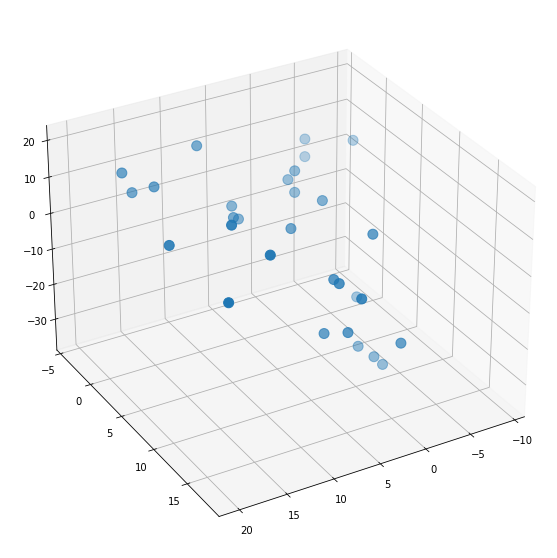

In [1]:
# from math import sqrt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy as cp
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

#мн-во образов
mn = [(0,1,1),(0,1,7),(5,7,4),
      (0,5,5),(9,4,5),(7,1,2),
      (10,0,19),(0,12,7),(-5,-4,5),
      (20,10,15),(0,16,-16),(-1,9,-30),
      (18,0,17),(6,18,4),(17,0,11),(14,16,18),
      (5,13,0),(-5,-4,0),(5,15,-11),(-3,10,-35),
      (16,2,15),(6,15,3),(-9,-2,5),(0,0,3),
      (19,17,11),(6,13,-14),(-4,5,-25),(15,12,20),
      (-2,10,-32),(7,2,0)]

#формируем данные для отображения
data = []
x,y,z = [],[],[]
for i in mn:
    data.append([i[0],i[1],i[2]])
    x.append(i[0])
    y.append(i[1])
    z.append(i[2])

fig = plt.figure(figsize=(12.,10.))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)
ax.scatter(x,y,z,s=100)

In [2]:
#метод евклида
def euclid(a,b,h=False):
    d = 0
    if(h != False):
        for i in range(len(a)):
            d += h[i]*(a[i]-b[i])**2 #учет веса
    else:
        for i in range(len(a)):
            d += (a[i]-b[i])**2
    return sqrt(d)

#метод доминирования
def domin(a,b,h=False):
    d = 0
    if(h != False):
        d = [h[i]*abs(a[i]-b[i]) for i in range(len(a))]
    else:
        d = [abs(a[i]-b[i]) for i in range(len(a))]
    return max(d) #берем максимум среди признаков

#расстояние между центрами разных кластеров
def center(a,b, method,h=False):
    p1 = [sum([i[0] for i in a])/len(a),sum([i[1] for i in a])/len(a),sum([i[2] for i in a])/len(a)]
    p2 = [sum([i[0] for i in b])/len(b),sum([i[1] for i in b])/len(b),sum([i[2] for i in b])/len(b)]
    return method(p1,p2,h)

#расстояние между ближайшими точками разных кластеров
def dclose(a,b,method,h=False):
    ds = []
    for i in a:
        for j in b:
            ds.append(method(i,j,h))
    return min(ds)

#кластеризация методом слияния
def cluster(data,m1,m2,k,h=False):
    n = len(data) #начальное кол-во кластеров

    #все элементы принадлежат разным кластерам
    cls = {}
    for i in range(n):
        cls[i] = [data[i]]
        
    while(n != k):
        #формируем расстояния между кластерами, чтобы далее два самых близких из них слить в один
        ds = {}
        for i,pts1 in cls.items():
            ds[i] = {}
            for j,pts2 in cls.items():
                if(i != j):
                    ds[i][j] = m2(pts1,pts2,m1,h)
            
        #находим минимум расстояния между кластерами
        idx = next(iter(ds))
        jdx = next(iter(ds[idx]))
        for i,pts1 in ds.items():
            for j,pts2 in pts1.items():
                if(ds[idx][jdx] > ds[i][j]):
                    idx = i
                    jdx = j

        cls[idx] += cls[jdx] #добавляем данные в первый найденный кластер
        del cls[jdx] #убираем данные из второго найденного кластера
        n -= 1 #уменьшаем кол-во кластеров на 1
        
    return cls #возвращаем сформированные кластеры

#нормализация данных
def normalize(data):
    #нормировка данных методом минимакса
    mx = [max(i[0] for i in data),max(i[1] for i in data),max(i[2] for i in data)]
    ms = [min(i[0] for i in data),min(i[1] for i in data),min(i[2] for i in data)]
    norm = []
    for d in data:
        norm.append(d)
        for i in range(len(d)):
            norm[len(norm)-1][i] = (d[i] - ms[i])/(mx[i]-ms[i])
    return norm

#расчет дисперсии
def disp(ls):
    avg = sum(ls)/len(ls)
    d = 0
    for i in ls:
        d += (i-avg)**2
    return d/len(ls)

#получение весов
def weights(norm):
    h = []
    for i in range(3):
        h.append(1/disp([b[i] for b in norm]))
    return h

IntSlider(value=3, description='Кластеры:', max=10, min=2)

Расстояние между образами


RadioButtons(options=('Евклида', 'Доминирования'), value='Евклида')

Расстояние между кластерами


RadioButtons(options=('Между центрами', 'Ближнего соседа'), value='Между центрами')

Нормирование данных


Checkbox(value=False)

Введение весов


Checkbox(value=True)

Углы для отрисовки данных:


IntSlider(value=38, description='Alpha:', max=90, min=1)

IntSlider(value=60, description='Beta:', max=90, min=1)

Button(description='Запустить', style=ButtonStyle())

Результат кластеризации:


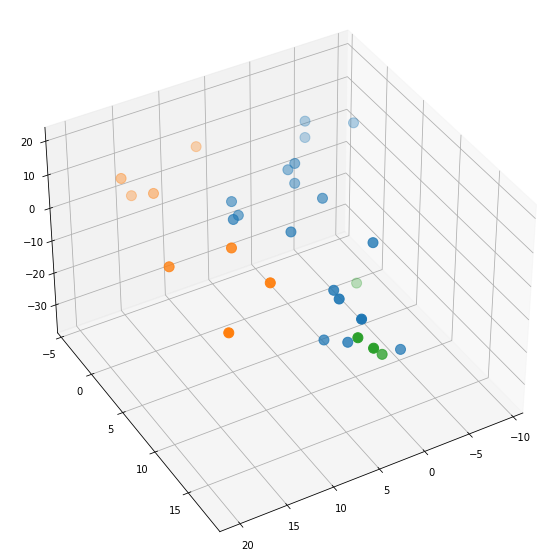

In [3]:
#отрисовка меню выбора параметров и самого 3д графика

#отрисовка 3d рисунка
def paint3d(cls,a=30,b=60):
    fig = plt.figure(figsize=(12.,10.))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(a, b)
    for k,v in cls.items():
        x,y,z = [p[0] for p in v],[p[1] for p in v],[p[2] for p in v]
        ax.scatter(x,y,z,s=100,depthshade=True)

#кол-во кластеров
slider = widgets.IntSlider(
    min=2,
    max=10,
    step=1,
    description='Кластеры:',
    value=3
)

#первый метод - расчет расстояния между образами
btn1 = widgets.RadioButtons(
    options=['Евклида', 'Доминирования'],
    disabled=False
)

#второй метод - расчет расстояния между кластерами
btn2 = widgets.RadioButtons(
    options=['Между центрами', 'Ближнего соседа'],
    disabled=False
)

#ввод нормализации данных
box1 = widgets.Checkbox(False)

#ввод весов
box2 = widgets.Checkbox(False)

#углы для поворота рисунка
alpha = widgets.IntSlider(
    min=1,
    max=90,
    step=1,
    description='Alpha:',
    value=30
)

beta = widgets.IntSlider(
    min=1,
    max=90,
    step=1,
    description='Beta:',
    value=60
)

#кнопка для применения изменений
start = widgets.Button(description='Запустить')

#данные для тестирования
dataset = cp.deepcopy(data)

#для упрощения
def menu():
    display(slider)
    print('Расстояние между образами')
    display(btn1)
    print('Расстояние между кластерами')
    display(btn2)
    print('Нормирование данных')
    display(box1)
    print('Введение весов')
    display(box2)
    print('Углы для отрисовки данных:')
    display(alpha)
    display(beta)
    display(start)

#метод для применения изменений
def on_change(btn):
    dataset = cp.deepcopy(data)
    clear_output()
    menu()
    m1 = btn1.value #первый метод
    m2 = btn2.value #второй
    size = slider.value #кол-во кластеров
    nr = box1.value #с нормализацией
    w = box2.value #с весами
    h = False
    if(m1 == 'Евклида'):
        m1 = euclid
    else:
        m1 = domin
    if(m2 == 'Между центрами'):
        m2 = center
    else:
        m2 = dclose
    if(nr):
        dataset = normalize(dataset)
    if(w):
        h = weights(dataset)
    cls = cluster(dataset,m1,m2,size,h)
    print('Результат кластеризации:')
    paint3d(cls,alpha.value,beta.value)
 
menu()
start.on_click(on_change)